In [ ]:
!pip install tensorflow tensorflow-addons opencv-python pandas tqdm kaggle mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
!kaggle competitions download -c deepfake-detection-challenge
!unzip -q deepfake-detection-challenge.zip -d dfdc_data

403 - Forbidden - You must accept this competition's rules before you'll be able to download files.
unzip:  cannot find or open deepfake-detection-challenge.zip, deepfake-detection-challenge.zip.zip or deepfake-detection-challenge.zip.ZIP.


In [ ]:
!pip install kaggle --upgrade
!pip install kagglehub

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [ ]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
 99% 3.72G/3.75G [00:40<00:00, 160MB/s]
100% 3.75G/3.75G [00:40<00:00, 99.8MB/s]


In [ ]:
!unzip -q 140k-real-and-fake-faces.zip -d dfdc_faces

In [ ]:
!ls dfdc_faces

real_vs_fake  test.csv	train.csv  valid.csv


In [ ]:
import os
import shutil

# Create directories
os.makedirs("dfdc_faces/train/real", exist_ok=True)
os.makedirs("dfdc_faces/train/fake", exist_ok=True)
os.makedirs("dfdc_faces/val/real", exist_ok=True)
os.makedirs("dfdc_faces/val/fake", exist_ok=True)

In [ ]:

import os

# Check the actual structure
print("Contents of 'dfdc_faces':", os.listdir("dfdc_faces"))
print("\nContents of 'dfdc_faces/real_vs_fake':", os.listdir("dfdc_faces/real_vs_fake"))

Contents of 'dfdc_faces': ['train.csv', 'val', 'real_vs_fake', 'valid.csv', 'test.csv', 'train']

Contents of 'dfdc_faces/real_vs_fake': ['real-vs-fake']


In [ ]:
import os

# Check root folder
print("Root folder:", os.listdir("dfdc_faces"))

# Check subfolder structure
try:
    print("\nContents of 'real_vs_fake':", os.listdir("dfdc_faces/real_vs_fake"))
except FileNotFoundError:
    print("\nFolder 'real_vs_fake' does NOT exist. Checking alternative paths...")

# Check if the dataset is nested under a different folder (common issue)
if os.path.exists("dfdc_faces/real-vs-fake"):
    print("\nFound 'real-vs-fake' folder!")
    print("Contents:", os.listdir("dfdc_faces/real-vs-fake"))

Root folder: ['train.csv', 'val', 'real_vs_fake', 'valid.csv', 'test.csv', 'train']

Contents of 'real_vs_fake': ['real-vs-fake']


In [ ]:
import os
import shutil

# Rename the nested folder
os.rename("dfdc_faces/real_vs_fake/real-vs-fake", "dfdc_faces/real_vs_fake/data")

# Verify the new structure
print("Updated structure:", os.listdir("dfdc_faces/real_vs_fake"))

Updated structure: ['data']


In [ ]:
data_path = "dfdc_faces/real_vs_fake/data"
print("Contents of 'data':", os.listdir(data_path))

Contents of 'data': ['valid', 'test', 'train']


In [ ]:
# Training data path
train_real_path = "dfdc_faces/real_vs_fake/data/train/real"
print("Sample real training images:", os.listdir(train_real_path)[:5])

# Validation data path
val_real_path = "dfdc_faces/real_vs_fake/data/valid/real"
print("Sample real validation images:", os.listdir(val_real_path)[:5])

Sample real training images: ['11765.jpg', '31119.jpg', '55489.jpg', '19977.jpg', '60831.jpg']
Sample real validation images: ['50365.jpg', '46741.jpg', '18507.jpg', '33629.jpg', '64367.jpg']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "dfdc_faces/real_vs_fake/data/train",  # Updated path
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

# Validation data
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "dfdc_faces/real_vs_fake/data/valid",  # Updated path
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
print("Training classes:", train_generator.class_indices)
print("Number of training samples:", train_generator.samples)
print("\nValidation classes:", val_generator.class_indices)
print("Number of validation samples:", val_generator.samples)

Training classes: {'fake': 0, 'real': 1}
Number of training samples: 100000

Validation classes: {'fake': 0, 'real': 1}
Number of validation samples: 20000


In [ ]:
#Build the Hybrid Model (Xception + ViT)

import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Reshape, LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.models import Model

# Load pre-trained Xception (freeze initial layers)
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

# Vision Transformer (ViT) block
def vit_block(inputs, num_heads=8, dim=768):
    # Self-attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=dim//num_heads)(x, x)
    x = Add()([attn, inputs])

    # Feed-forward
    x_norm = LayerNormalization(epsilon=1e-6)(x)
    x_dense = Dense(dim*4, activation='gelu')(x_norm)
    x_dense = Dense(dim)(x_dense)
    return Add()([x_dense, x])

# Combine Xception with ViT
inputs = Input(shape=(299, 299, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)  # Shape: (batch_size, 2048)

# Reshape for ViT using Keras Reshape layer
x = Reshape((1, 2048))(x)
x = Dense(768)(x)  # Project to ViT dimension (768)

# Add 4 ViT blocks
for _ in range(4):
    x = vit_block(x)

# Classifier
x = Dense(256, activation='relu')(x)
x = Flatten()(x)  # <-- Fixes the shape mismatch
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Compile the Model

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)



In [ ]:
#Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7606 - auc: 0.8391 - loss: 0.5060

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1108s 343ms/step - accuracy: 0.7606 - auc: 0.8391 - loss: 0.5059 - val_accuracy: 0.8504 - val_auc: 0.9294 - val_loss: 0.3398
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1067s 341ms/step - accuracy: 0.8489 - auc: 0.9259 - loss: 0.3466 - val_accuracy: 0.8360 - val_auc: 0.9385 - val_loss: 0.3684
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8741 - auc: 0.9455 - loss: 0.2981

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1072s 343ms/step - accuracy: 0.8741 - auc: 0.9455 - loss: 0.2981 - val_accuracy: 0.8816 - val_auc: 0.9518 - val_loss: 0.2808
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1066s 341ms/step - accuracy: 0.8892 - auc: 0.9574 - loss: 0.2638 - val_accuracy: 0.8727 - val_auc: 0.9512 - val_loss: 0.3046
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9038 - auc: 0.9675 - loss: 0.2305

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1072s 343ms/step - accuracy: 0.9038 - auc: 0.9675 - loss: 0.2305 - val_accuracy: 0.8835 - val_auc: 0.9558 - val_loss: 0.2802
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1065s 341ms/step - accuracy: 0.9161 - auc: 0.9740 - loss: 0.2057 - val_accuracy: 0.8867 - val_auc: 0.9614 - val_loss: 0.2803
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1064s 341ms/step - accuracy: 0.9260 - auc: 0.9791 - loss: 0.1852 - val_accuracy: 0.8859 - val_auc: 0.9604 - val_loss: 0.2803
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9373 - auc: 0.9841 - loss: 0.1599

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1070s 342ms/step - accuracy: 0.9373 - auc: 0.9841 - loss: 0.1599 - val_accuracy: 0.9035 - val_auc: 0.9656 - val_loss: 0.2618
Epoch 9/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1067s 341ms/step - accuracy: 0.9420 - auc: 0.9865 - loss: 0.1465 - val_accuracy: 0.8903 - val_auc: 0.9626 - val_loss: 0.3053
Epoch 10/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9347 - auc: 0.9835 - loss: 0.1787

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1071s 343ms/step - accuracy: 0.9347 - auc: 0.9835 - loss: 0.1787 - val_accuracy: 0.9053 - val_auc: 0.9677 - val_loss: 0.2456


In [ ]:
#Evaluate Model Performance
#Run the evaluation code to check accuracy and AUC on the validation set:

loss, accuracy, auc = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation AUC: {auc:.3f}")

#Good Result: Accuracy >85%, AUC >0.95 → Proceed to predictions.

#Poor Result: Accuracy <80% → Jump to "Improving the Model" below.

625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 252ms/step - accuracy: 0.9052 - auc: 0.9670 - loss: 0.2487
Validation Accuracy: 90.53%
Validation AUC: 0.968


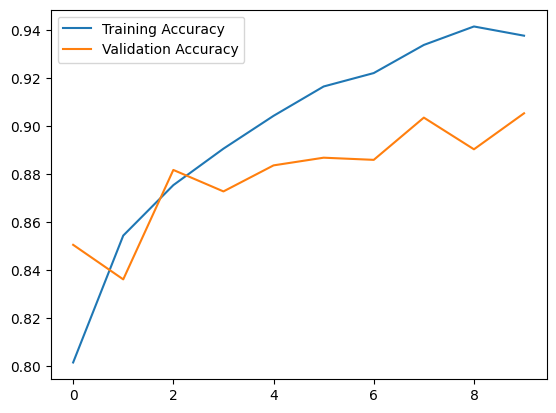

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
#Overfitting: Validation loss rises while training loss drops → Add dropout/data augmentation.

#Underfitting: Both metrics stagnate → Train longer or tweak architecture.

In [ ]:
model.save('deepfake_detector.h5')  # HDF5 format

In [ ]:
model.save('deepfake_detector.keras')  #  Use .keras extension newer

# To load later the model :
#from tensorflow.keras.models import load_model
#loaded_model = load_model('deepfake_detector.keras')

In [ ]:
#If Performance is Good (Accuracy >85%)

#Test on Unseen Data
def predict_deepfake(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return "Fake" if prediction[0][0] > 0.5 else "Real"

print(predict_deepfake("path/to/your/test_image.jpg"))

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/your/test_image.jpg'

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your test image (e.g., "test_image.jpg")

Saving real2.png to real2.png


In [ ]:
print(predict_deepfake("real2.png"))

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your test image (e.g., "test_image.jpg")

In [ ]:
print(predict_deepfake("fake2.png"))

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your test image (e.g., "test_image.jpg")

In [ ]:
print(predict_deepfake("fake1.png"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Fake


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your test image (e.g., "test_image.jpg")

Saving real1.png to real1.png


In [ ]:
print(predict_deepfake("real1.png"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Fake


In [ ]:
import os

# Check root folder structure
print("Root folder:", os.listdir("dfdc_faces"))

# Check 'real_vs_fake' subfolder
print("\nContents of 'real_vs_fake':", os.listdir("dfdc_faces/real_vs_fake"))

# Check validation folder
try:
    print("\nValidation real images:", os.listdir("dfdc_faces/real_vs_fake/valid/real")[:5])
except FileNotFoundError:
    print("\nPath 'dfdc_faces/real_vs_fake/valid/real' does not exist. Check your dataset structure.")

Root folder: ['train.csv', 'val', 'real_vs_fake', 'valid.csv', 'test.csv', 'train']

Contents of 'real_vs_fake': ['data']

Path 'dfdc_faces/real_vs_fake/valid/real' does not exist. Check your dataset structure.


In [ ]:
# Training data path
train_path = "dfdc_faces/real_vs_fake/data/train"

# Validation data path
val_path = "dfdc_faces/real_vs_fake/data/valid"

# Test data path
test_path = "dfdc_faces/real_vs_fake/data/test"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    train_path,  # Updated path
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

# Validation data generator
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_path,  # Updated path
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
import os

# Check validation real images
print(os.listdir("dfdc_faces/real_vs_fake/data/valid/real")[:5])  # Should list files like "real_00000.jpg"

# Check validation fake images
print(os.listdir("dfdc_faces/real_vs_fake/data/valid/fake")[:5])  # Should list files like "fake_00000.jpg"

['50365.jpg', '46741.jpg', '18507.jpg', '33629.jpg', '64367.jpg']
['940F4TANHF.jpg', 'SBD0H9NQ2W.jpg', 'UEOCVICGO3.jpg', 'DUSQBZYSHE.jpg', '2IQDXSUZOW.jpg']


In [ ]:
# Example: Predict on a real validation image
real_test_path = "dfdc_faces/real_vs_fake/data/valid/real/real_00000.jpg"
print(predict_deepfake(real_test_path))  # Should output "Real"

# Example: Predict on a fake validation image
fake_test_path = "dfdc_faces/real_vs_fake/data/valid/fake/fake_00000.jpg"
print(predict_deepfake(fake_test_path))  # Should output "Fake"

FileNotFoundError: [Errno 2] No such file or directory: 'dfdc_faces/real_vs_fake/data/valid/real/real_00000.jpg'

In [ ]:
# Evaluate on validation data
loss, accuracy, auc = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation AUC: {auc:.3f}")

# If you have a test set:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "dfdc_faces/real_vs_fake/data/test",
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)
test_loss, test_acc, test_auc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}% | Test AUC: {test_auc:.3f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 252ms/step - accuracy: 0.9039 - auc: 0.9674 - loss: 0.2491
Validation Accuracy: 90.53%
Validation AUC: 0.968
Found 20000 images belonging to 2 classes.
625/625 ━━━━━━━━━━━━━━━━━━━━ 157s 250ms/step - accuracy: 0.9052 - auc: 0.9684 - loss: 0.2428
Test Accuracy: 90.22% | Test AUC: 0.967


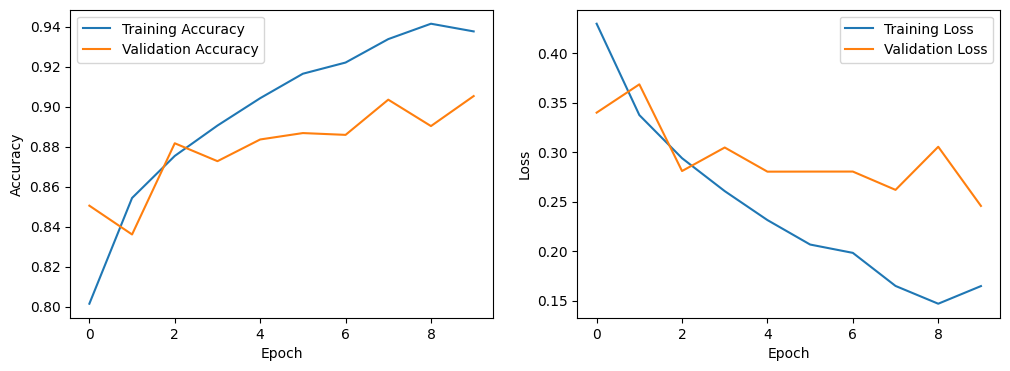

In [ ]:
#Visualize Training History
#Plot accuracy and loss curves to diagnose overfitting/underfitting:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Save the Model Properly
model.save('deepfake_detector.keras')  # New format

In [ ]:
# Fine-Tune (Optional)
#Unfreeze the Xception base layers and train with a smaller learning rate:

base_model.trainable = True  # Unfreeze Xception
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy')
history_fine = model.fit(train_generator, epochs=5, validation_data=val_generator)

KeyboardInterrupt: 

In [ ]:
#step-by-step guide to load your saved model and detect deepfakes in images or videos in Google Colab
#and to work on videos
# see deepseek